### Multiples Valuation

In [28]:
import numpy as np
import pandas as pd

from quantifilib.models.valuation.multiple import MultiplesValuation

pe_val = MultiplesValuation.from_params(
    params = {
        "ratio": "PE", 
        "multiple": 15.0
    }
)
out = pe_val.evaluate(
    inputs = {
        "eps": 8.0, 
        "shares_out": 100.0, 
        "timing": "forward"
    }
)

In [29]:
out

{'multiple_used': 15.0,
 'equity_value': 12000.0,
 'value_per_share': 120.0,
 'bridge': {},
 'meta': {'ratio': 'PE', 'timing': 'forward', 'source': 'fixed', 'agg': None}}

In [30]:
ev_ebitda = MultiplesValuation.from_params(
    params = {
        "ratio": "EV/EBITDA", 
        "agg": "median",
        "peer_multiples": [8.5, 9.2, 7.9, 10.1]
    }
)
res = ev_ebitda.evaluate({
    "ebitda": 500.0,
    "net_debt": 1200.0,
    "minority_interest": 50.0,
    "preferred_equity": 0.0,
    "associates": 20.0,
    "shares_out": 300.0,
    "timing": "forward"
})

In [31]:
res

{'multiple_used': 8.85,
 'equity_value': 3195.0,
 'value_per_share': 10.65,
 'bridge': {'EV': 4425.0,
  'net_debt': 1200.0,
  'minority_interest': 50.0,
  'preferred_equity': 0.0,
  'associates': 20.0},
 'meta': {'ratio': 'EV/EBITDA',
  'timing': 'forward',
  'source': 'peers',
  'agg': 'median'}}

In [32]:
p_fcf = MultiplesValuation.from_params(
    params = {
        "ratio": "P/FCF",
        "multiple": 18.0
    }
)
ans = p_fcf.evaluate(
    inputs = {
        "fcfps": 6.2, 
        "shares_out": 250.0
    }
)

In [33]:
ans

{'multiple_used': 18.0,
 'equity_value': 27900.000000000004,
 'value_per_share': 111.60000000000001,
 'bridge': {},
 'meta': {'ratio': 'P/FCF', 'timing': None, 'source': 'fixed', 'agg': None}}

### from Time Seires

In [34]:
np.random.seed(42)
idx = pd.date_range("2023-01-31", periods=24, freq="ME")

eps = 8.0 * (1 + 0.10/12) ** np.arange(24) * np.exp(np.random.normal(0, 0.02, 24))  # gentle growth + noise
peer_mult_pe = pd.DataFrame({
    "PeerA": 15 + np.random.normal(0, 0.5, 24),
    "PeerB": 14.5 + np.random.normal(0, 0.6, 24),
    "PeerC": 15.2 + np.random.normal(0, 0.4, 24),
}, index=idx)
df_pe = pd.DataFrame({"EPS": eps}, index=idx)
shares_series = pd.Series(300.0, index=idx)

In [35]:
pe_model = MultiplesValuation("PE")

target_price_pe = pe_model.evaluate_df(
    df_pe, 
    shares_out=shares_series, 
    peer_multiples=peer_mult_pe, 
    agg="median"
)

<Axes: >

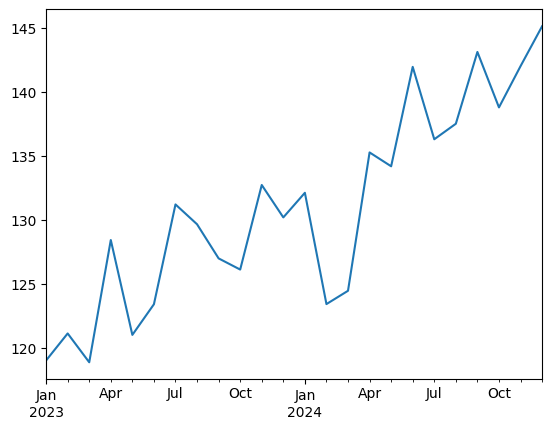

In [36]:
target_price_pe['target_price'].plot()

In [37]:
ebitda = 500 * (1 + 0.08/12) ** np.arange(24) * np.exp(np.random.normal(0, 0.03, 24))
net_debt = 1200 + np.linspace(0, 200, 24) + np.random.normal(0, 20, 24)
df_ev = pd.DataFrame(
    {"EBITDA": ebitda, "NetDebt": net_debt}, 
    index=idx
)

In [38]:
ev_model = MultiplesValuation("EV/EBITDA")
target_price_ev = ev_model.evaluate_df(
    df_ev, 
    shares_out=shares_series, 
    multiple=9.5
)

<Axes: >

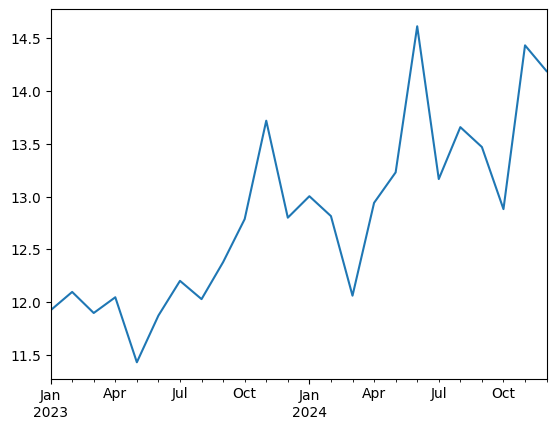

In [39]:
target_price_ev['target_price'].plot()

### DCF Valuation

Gordon의 FCFF 방법

In [40]:
from quantifilib.models.valuation.cash_flow import DCFValuation

dcf = DCFValuation.from_params(
    params = {
        'mode':'fcff',
        'terminal':'g',
        'mid_year':True
    }
)
res = dcf.evaluate({
    'ebit':       [200, 220, 242, 266, 293],
    'dep':        [50,  52,  55,  58,  60],
    'capex':      [80,  85,  90,  95,  100],
    'delta_nwc':  [10,  12,  13,  14,  15],
    'tax_rate':   0.25,
    'wacc':       0.09,
    'g':          0.03,
    'net_debt':   1200.0,
    'shares_out': 300.0,
})

In [41]:
res

{'firm_value': np.float64(2459.1350893953163),
 'equity_value': 1259.1350893953163,
 'value_per_share': 4.197116964651054,
 'breakdown': {'PV_FCF': 540.0591659365446,
  'PV_Terminal': 1919.0759234587717,
  'FCF': array([110.  , 120.  , 133.5 , 148.5 , 164.75]),
  'TV': 2828.2083333333335,
  'terminal_method': 'g'}}

FCFE with exit multiple

In [42]:
dcf_e = DCFValuation.from_params(
    params = {
        'mode':'fcfe',
        'terminal':'exit',
        'mid_year':True
    }
)
res_e = dcf_e.evaluate({
    'fcfe':       [120, 135, 150, 165, 180],
    'ke':         0.11,
    'exit_multiple': 12.0,
    'exit_metric':   200.0,     # e.g., last-year equity cash earnings proxy
    'shares_out':  300.0,
})

In [43]:
res_e

{'firm_value': None,
 'equity_value': 2072.522056095238,
 'value_per_share': 6.908406853650793,
 'breakdown': {'PV_FCF': 571.9466053122951,
  'PV_Terminal': 1500.5754507829429,
  'FCF': array([120., 135., 150., 165., 180.]),
  'TV': 2400.0,
  'terminal_method': 'exit'}}

In [44]:
from quantifilib.models.valuation.growth import GordonGrowthValuation

gg = GordonGrowthValuation()

res = gg.evaluate({
    "shares_out": 1_000_000,
    "dps": 2.0,           # 직전 DPS
    "growth": 0.03,       # g
    "cost_of_equity": 0.08  # r
})

In [45]:
res

{'equity_value': 41199999.99999999,
 'value_per_share': 41.199999999999996,
 'meta': {'model': 'GordonGrowth (single-stage DDM)',
  'r': 0.08,
  'g': 0.03,
  'path': 'dps*(1+g)',
  'timing': None}}

In [48]:
idx = pd.date_range("2024-01-01", periods=3, freq="QE")
df = pd.DataFrame(
    {"DPS": [2.0, 2.1, 2.2], "Growth": [0.03, 0.03, 0.03], "CostOfEquity": [0.08, 0.08, 0.08]},
    index=idx
)
out = gg.evaluate_df(df, shares_out=1_000_000)

In [49]:
out

,target_price,equity_value,r,g,path
2024-03-31,41.20,41200000.0,0.08,0.03,DPS*(1+g)
2024-06-30,43.26,43260000.0,0.08,0.03,DPS*(1+g)
2024-09-30,45.32,45320000.0,0.08,0.03,DPS*(1+g)
